# CNN Feature Maps & Grad-CAM Educational Notebook

This notebook builds intuition for CNN feature maps, hooks, and Grad-CAM with both toy and real examples. Interactive exercises are included for hands-on learning.

## Introduction

CNNs learn hierarchical image features:
- Early layers: edges, corners, textures
- Middle layers: object parts
- Late layers: semantic patterns (objects)

Grad-CAM highlights which image regions influence a class prediction.

We will use:
- Toy CNN for intuitive feature map understanding
- Pretrained ResNet18 for real image examples

## Toy CNN Example: Feature Maps Intuition

We start small: a 5x5 grayscale image with two filters (vertical and horizontal edges).

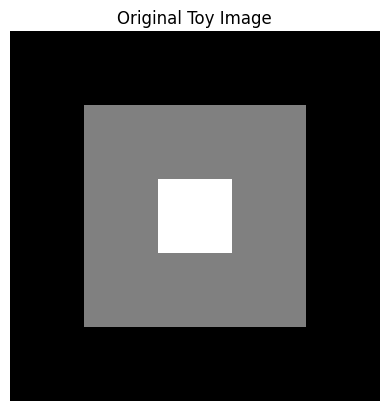

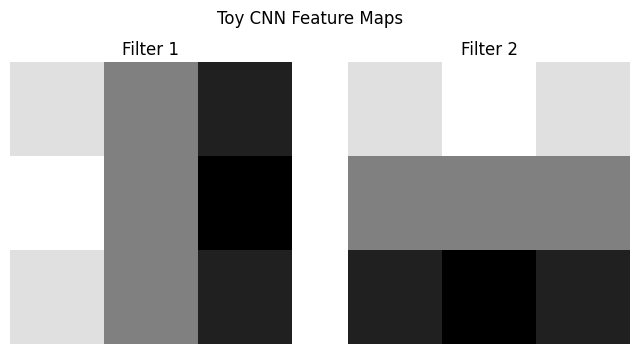

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

image = torch.tensor([[0,0,0,0,0],
                      [0,1,1,1,0],
                      [0,1,2,1,0],
                      [0,1,1,1,0],
                      [0,0,0,0,0]], dtype=torch.float32)
plt.imshow(image, cmap='gray')
plt.title('Original Toy Image')
plt.axis('off')
plt.show()
input_tensor = image.unsqueeze(0).unsqueeze(0)
class ToyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 2, kernel_size=3, bias=False)
        self.conv.weight.data[0,0] = torch.tensor([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=torch.float32)
        self.conv.weight.data[1,0] = torch.tensor([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=torch.float32)
    def forward(self, x):
        return self.conv(x)
toy_cnn = ToyCNN()
output = toy_cnn(input_tensor)
fig, axes = plt.subplots(1,2,figsize=(8,4))
for i in range(2):
    axes[i].imshow(output[0,i].detach(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')
plt.suptitle('Toy CNN Feature Maps')
plt.show()

### Try It Yourself
- Try to Modify the filters to detect diagonal patterns.
- Observe how feature maps change.

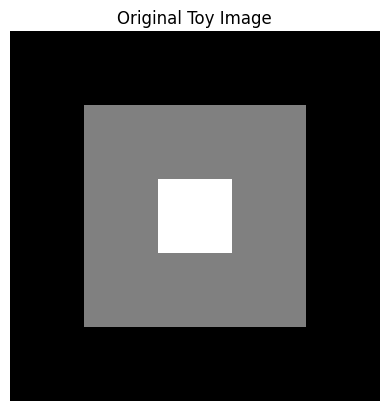

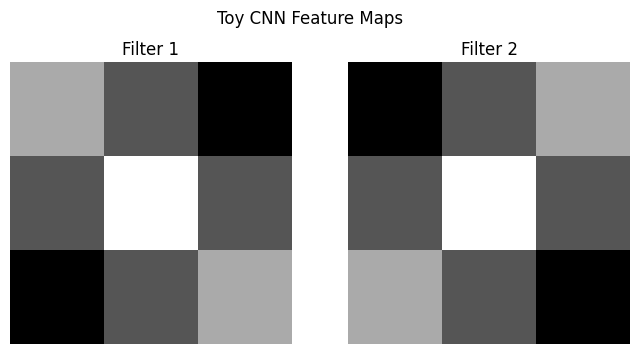

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

image = torch.tensor([[0,0,0,0,0],
                      [0,1,1,1,0],
                      [0,1,2,1,0],
                      [0,1,1,1,0],
                      [0,0,0,0,0]], dtype=torch.float32)
plt.imshow(image, cmap='gray')
plt.title('Original Toy Image')
plt.axis('off')
plt.show()
input_tensor = image.unsqueeze(0).unsqueeze(0)
class MyToyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 2, kernel_size=3, bias=False)
        self.conv.weight.data[0,0] = torch.tensor([[1,0,0],[0,1,0],[0,0,1]], dtype=torch.float32)
        self.conv.weight.data[1,0] = torch.tensor([[0,0,1],[0,1,0],[1,0,0]], dtype=torch.float32)
    def forward(self, x):
        return self.conv(x)
toy_cnn = MyToyCNN()
output = toy_cnn(input_tensor)
fig, axes = plt.subplots(1,2,figsize=(8,4))
for i in range(2):
    axes[i].imshow(output[0,i].detach(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')
plt.suptitle('Toy CNN Feature Maps')
plt.show()

## Understanding Hooks in PyTorch

**Forward hooks** capture layer outputs (feature maps) during a forward pass.

**Backward hooks** capture gradients flowing backward.

This lets us visualize what a CNN sees (forward) and what contributes to a class (backward, for Grad-CAM).

In [ ]:
activation = None
def hook_fn(module, input, output):
    global activation
    activation = output.detach()

## About ImageNet

ImageNet is a large-scale dataset for visual recognition:
- Over 14 million images
- 1,000 object classes
- Enables CNNs to learn general-purpose features

Pretrained models like ResNet18 have learned rich hierarchical features. Grad-CAM can highlight which parts of these features influence predictions.

## Pretrained CNN: ResNet18 Example

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


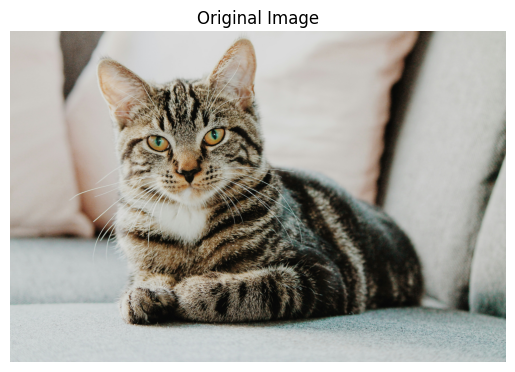

In [ ]:
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np

model = torchvision.models.resnet18(pretrained=True)
model.eval()
url = 'https://images.unsplash.com/photo-1518791841217-8f162f1e1131'
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
input_tensor = preprocess(img).unsqueeze(0)
plt.imshow(np.array(img))
plt.axis('off')
plt.title('Original Image')
plt.show()

### Display Predicted ImageNet Class

In [ ]:
with torch.no_grad():
    output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
from torchvision import models
imagenet_classes = dict(enumerate(models.ResNet18_Weights.DEFAULT.meta['categories']))
pred_label = imagenet_classes[pred_class]
print('Predicted class index:', pred_class)
print('Predicted label:', pred_label)

Predicted class index: 281
Predicted label: tabby


## Feature Map Extraction with Hooks

In [ ]:
layers_to_hook = [model.layer1, model.layer2, model.layer3, model.layer4]
feature_maps = {}
def hook_fn(name):
    def forward_hook(module, input, output):
        feature_maps[name] = output.detach()
    return forward_hook
hooks = []
for idx, layer in enumerate(layers_to_hook):
    hooks.append(layer.register_forward_hook(hook_fn(f'layer{idx+1}')))
with torch.no_grad():
    _ = model(input_tensor)
for h in hooks:
    h.remove()

## Visualizing Feature Maps

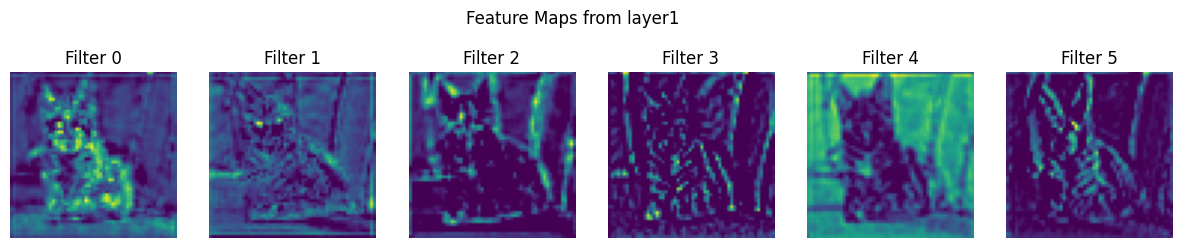

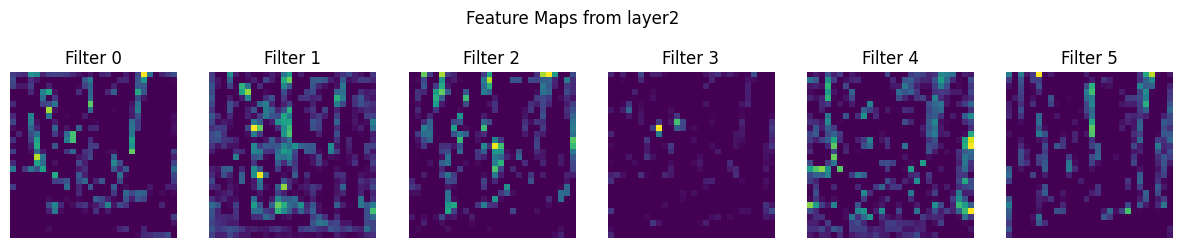

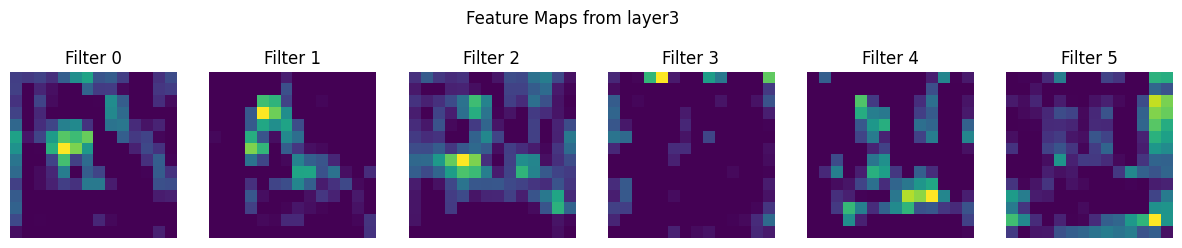

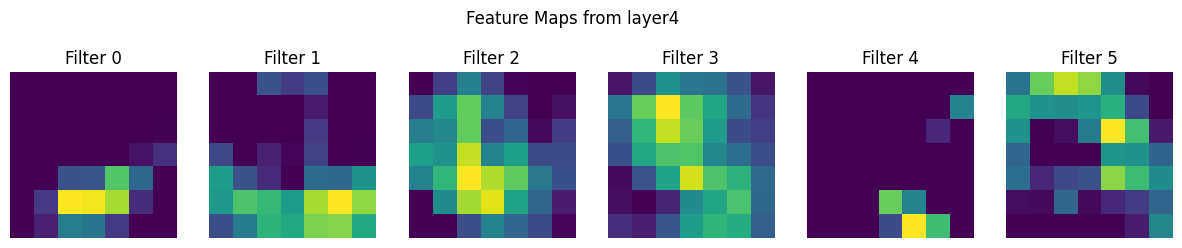

In [ ]:
for name, fmap in feature_maps.items():
    fig, axes = plt.subplots(1,6,figsize=(15,3))
    for i in range(6):
        axes[i].imshow(fmap[0,i].cpu(), cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i}')
    plt.suptitle(f'Feature Maps from {name}')
    plt.show()

### Try It Yourself
- Hook a different layer (e.g., layer2[0]) and visualize feature maps.
- Compare to layer1 and layer4.

## Grad-CAM Implementation

In [ ]:
import cv2
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    def generate_cam(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output[0, target_class]
        loss.backward()
        pooled_grads = torch.mean(self.gradients, dim=[0,2,3])
        for i in range(self.activations.shape[1]):
            self.activations[0,i,:,:] *= pooled_grads[i]
        heatmap = torch.sum(self.activations[0], dim=0)
        heatmap = torch.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.cpu().numpy()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


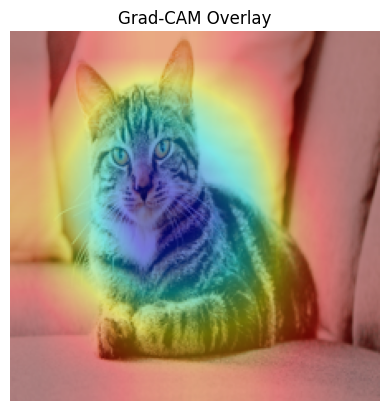

In [ ]:
target_layer = model.layer4[-1].conv2
grad_cam = GradCAM(model, target_layer)
cam = grad_cam.generate_cam(input_tensor, pred_class)
img_resized = np.array(img.resize((224,224)))
heatmap = cv2.resize(cam, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap_color, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Grad-CAM Overlay')
plt.show()

### Try Your Own Image




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load ImageNet class labels
imagenet_classes = dict(enumerate(models.ResNet18_Weights.DEFAULT.meta['categories']))

def run_gradcam_on_path(image_path, model, grad_cam, classes, device):
    # Open image
    img = Image.open(image_path).convert('RGB')

    # Display original image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess
    preprocess = transforms.Compose([
      transforms.ToTensor(),
    ])
    input_tensor = preprocess(img).unsqueeze(0)

    # Forward pass
    model.eval()
    model.to(torch.device('cpu'))
    with torch.no_grad():
        input_tensor.to(torch.device('cpu'))
        output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    pred_label = classes[pred_class]

    print(f"Predicted class index: {pred_class}")
    print(f"Predicted class label: {pred_label}")

    # Grad-CAM
    cam = grad_cam.generate_cam(input_tensor, pred_class)
    img_resized = np.array(img.resize((128,128)))
    heatmap = cv2.resize(cam, (128,128))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap_color, 0.4, 0)

    # Display Grad-CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f"Grad-CAM Overlay\nPredicted: {pred_label}")
    plt.show()

In [ ]:
#Install Kaggle dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'best-alzheimer-mri-dataset-99-accuracy' dataset.
Path to dataset files: /kaggle/input/best-alzheimer-mri-dataset-99-accuracy


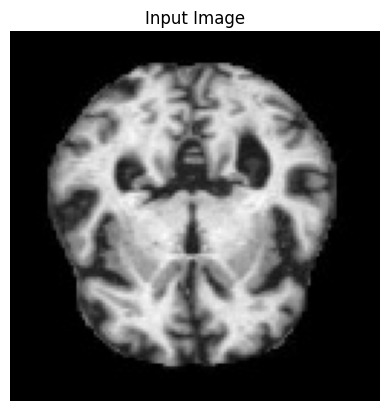

Predicted class index: 793
Predicted class label: shower cap


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


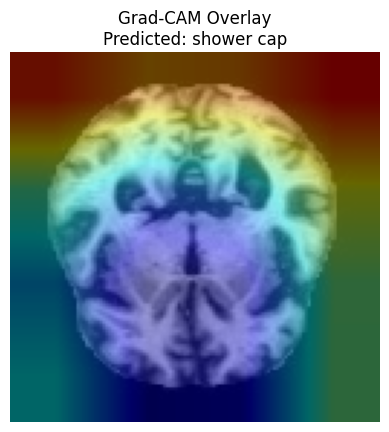

In [ ]:
run_gradcam_on_path(path + '/Combined Dataset/test/Mild Impairment/1 (10).jpg', model, grad_cam, imagenet_classes, device)

### Apply gradcam to your CNN model from Week 3

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 32

train_path = path + "/Combined Dataset/train"
test_path = path + "/Combined Dataset/test"
# Load training set from image directory
trainset = torchvision.datasets.ImageFolder(train_path,
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Load testing set from image directory
testset = torchvision.datasets.ImageFolder(test_path,
                                           transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [ ]:
class MRICNNModel(nn.Module):

  def __init__(self):
    super(MRICNNModel, self).__init__()
    # TODO: Add layers here
    self.layer1 = nn.Conv2d(3, 16, 3, padding=1)
    self.layer2 = nn.Conv2d(16, 32, 5, padding=1)
    self.layer3 = nn.Conv2d(32, 64, 7, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.linear = nn.Linear(10816, 10)
    self.final_classifier = nn.Linear(10, 4)

  def forward(self, x):

    # TODO: Pass input through layers
    x = self.relu(self.layer1(x))
    x = self.pool(x)
    x = self.relu(self.layer2(x))
    x = self.pool(x)
    x = self.relu(self.layer3(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.relu(self.linear(x))
    x = self.final_classifier(x)
    return x

In [ ]:
model = MRICNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model = model.to(device) #move model to GPU
print(device) #if you're not on GPU make sure to switch runtime to GPU (COLAB)

cuda


In [ ]:
for epoch in range(10):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    num_correct = 0

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        # TODO: move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        ## TODO: forwardprop + backprop + loss
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()

        # Calculate running number of correct predictions
        _, predicted_class = torch.max(output, 1)
        num_correct += (predicted_class == labels).sum().item()

        ## update model params (step optimizer)
        optimizer.step()

        # Calculate running loss
        train_running_loss += loss.detach().item()

    total_images = len(trainloader)*BATCH_SIZE
    train_acc = num_correct/total_images
    train_running_loss /= len(trainloader)
    print(f"Epoch: {epoch}, Loss: {train_running_loss}, Accuracy: {train_acc}")

Epoch: 0, Loss: 1.2676386810839175, Accuracy: 0.38681640625
Epoch: 1, Loss: 1.0280145686119795, Accuracy: 0.546875
Epoch: 2, Loss: 0.9361510599032045, Accuracy: 0.59794921875
Epoch: 3, Loss: 0.8553612941876054, Accuracy: 0.64716796875
Epoch: 4, Loss: 0.8058069026097655, Accuracy: 0.669921875
Epoch: 5, Loss: 0.779103821888566, Accuracy: 0.679296875
Epoch: 6, Loss: 0.7241745682433247, Accuracy: 0.70673828125
Epoch: 7, Loss: 0.6963812662288547, Accuracy: 0.71669921875
Epoch: 8, Loss: 0.666501940973103, Accuracy: 0.7251953125
Epoch: 9, Loss: 0.6420462546870113, Accuracy: 0.73095703125


In [ ]:
correct = 0
# Iterate over the data in the test_loader
for i, data in enumerate(testloader):
    # Get the image and label from data
    images, labels = data

    #move images and labels to device
    images = images.to(device)

    # TODO: Make a forward pass in the net with your image
    output = model(images)

    # Get predictions from softmax results of the CNN
    _, predicted = torch.max(output.data, 1)

    #TODO: Iterate through predicted and actual labels and count how many are correct
    predicted = predicted.cpu()
    correct += (predicted == labels).sum().item()


total_imgs = len(testloader)*BATCH_SIZE
acc = (correct/total_imgs)*100
print(f"Accuracy: {correct}/{total_imgs} = {acc:.2f}%")

Accuracy: 729/1280 = 56.95%


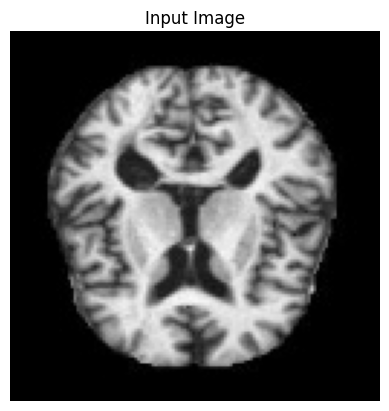

Predicted class index: 0
Predicted class label: Mild Impairment


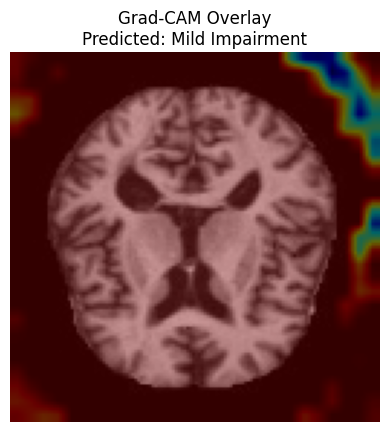

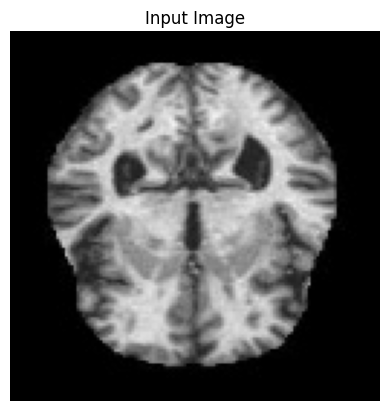

Predicted class index: 2
Predicted class label: Non-Impaired


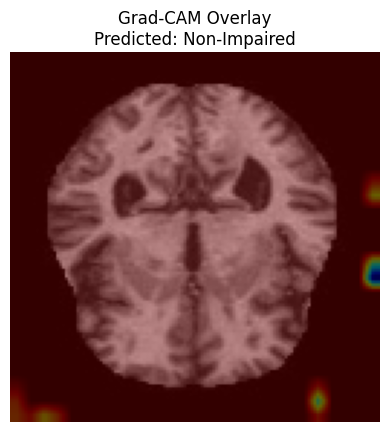

In [ ]:
mri_classes = {
    0: 'Mild Impairment',
    1: 'Moderate Impairment',
    2: 'Non-Impaired',
    3: 'Very Mild Impairment'
}
target_layer = model.layer3
grad_cam = GradCAM(model, target_layer)
run_gradcam_on_path(path + '/Combined Dataset/test/Moderate Impairment/12.jpg', model, grad_cam, mri_classes, device)
run_gradcam_on_path(path + '/Combined Dataset/test/Very Mild Impairment/1 (10).jpg', model, grad_cam, mri_classes, device)